# Practical Session 5 - Parallel Markov chains with multiprocessing and dask

Students (pair):
- [Mathieu CARON]([link](https://github.com/mcaron01/python_sdia))
- [Maxime BACQUET]([link](https://github.com/username2))


**Useful references for this lab**:

[1] `seaborn`: [official tutorial](https://seaborn.pydata.org/tutorial.html)

[2] `multiprocessing`: [documentation](https://docs.python.org/3/library/multiprocessing.html), [doc2](https://he-arc.github.io/livre-python/multiprocessing/index.html)

[3] `dask`: [documentation](http://numba.pydata.org/) 

## <a name="content">Contents</a>
- [Exercise 1: seaborn, a useful tool for data visualisation](#ex1)
- [Exercise 2: Simulating a discrete-time homogeneous Markov chain](#ex2)
- [Bonus: Parallel computing with Dask](#bonus)
---

In [1]:
%load_ext autoreload
%autoreload 2


## <a name="ex1">Exercise 1: seaborn, a useful tool for data visualisation</a> [(&#8593;)](#content)
 
The `seaborn` package can significantly enhance data and data analysis visualization. See the [tutorial page](https://seaborn.pydata.org/tutorial.html) for examples of effective predefined graphics. An example aimed at visualizing the empirical distributions of 9 realizations of a bivariate Gaussian random vector is reported below.

C:\Users\mathc\AppData\Local\Temp\ipykernel_7852\1179137102.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\mathc\AppData\Local\Temp\ipykernel_7852\1179137102.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\mathc\AppData\Local\Temp\ipykernel_7852\1179137102.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
C:\Users\mathc\AppData\Local\Temp\ipykernel_7852\1179137102.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True

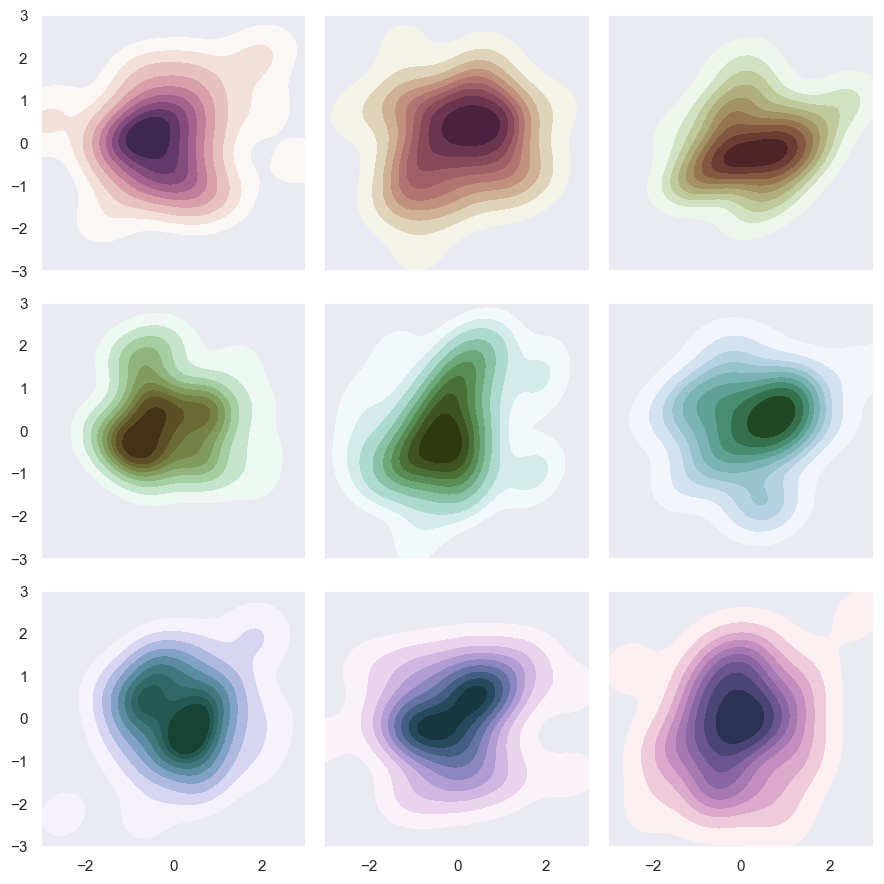

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="dark")
rng = np.random.default_rng(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
    x, y = rng.normal(size=(2, 50))
    sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)
    ax.set(xlim=(-3, 3), ylim=(-3, 3))

f.tight_layout()


1. Comment on the lines of codes related to the `seaborn` library to make their role explicit. More specifically comment on the KDE method.

**Answer:**

Voici les commentaires pour le code au dessus :

1. - `import matplotlib.pyplot as plt`: Import de la bibliothèque matplotlib pour les graphiques.
   - `import numpy as np`: Import de la bibliothèque numpy pour les opérations numériques.
   - `import seaborn as sns`: Import de la bibliothèque seaborn pour la visualisation de données.

2. `sns.set(style="dark")`: Définition du style des graphiques de seaborn comme sombre.
   `rng = np.random.default_rng(50)`: Initialisation d'un générateur de nombres aléatoires avec une graine de 50.

3. `f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)`: Création d'une figure avec une grille de 3x3 sous-graphiques.

4. Boucle pour itérer sur chaque sous-graphique :
   - `for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):`

5. `cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)`: Création d'une palette de couleurs cubehelix.

6. - `x, y = rng.normal(size=(2, 50))`: Génération de deux ensembles de 50 nombres aléatoires suivant une distribution normale.
   - `sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=ax)`: Tracé d'un KDE pour les données x et y.
   - `ax.set(xlim=(-3, 3), ylim=(-3, 3))`: Définition des limites des axes du sous-graphique.

7. `f.tight_layout()`: Ajustement automatique de la disposition des sous-graphiques.

Le KDE (Kernel Density Estimation) est une méthode de lissage de distribution qui est utilisée pour estimer la distribution de probabilité d'une variable aléatoire continue. C'est une technique utilisée en statistiques et en visualisation de données pour comprendre la forme et la tendance des données.


2. For one of the realizations, take a look at the documentation of [`sns.jointplot`](https://seaborn.pydata.org/examples/joint_kde.html) to display both the 2-D empirical distribution of the data, and 1D histograms of their distribution along each axis. 

**Answer:**

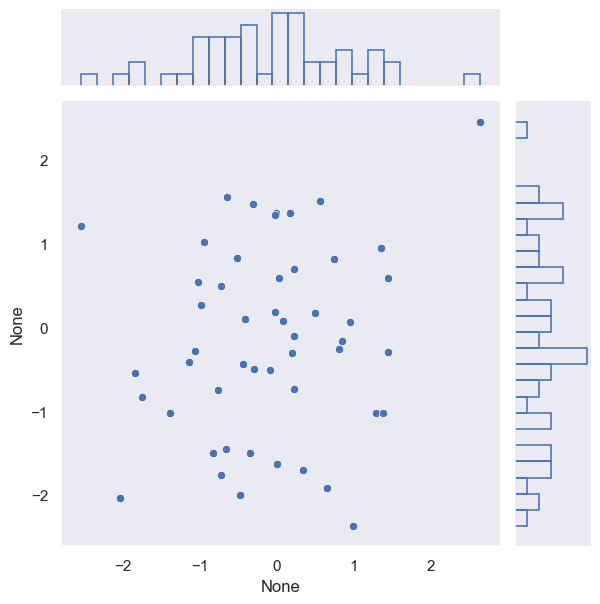

In [9]:
# On utilise sns.jointplot pour afficher la distribution 2D et les histogrammes 1D
joint_plot = sns.jointplot(x=x, y=y, kind="scatter", marginal_kws=dict(bins=25, fill=False))

# On enregistre l'image
joint_plot.savefig('img/joint_plot.png')


On observe bien le graphique en 2D avec la répartition de notre data en nuage de points. Et sur chaque axe la répartition 1D en histogramme de X et de Y.

## <a name="ex2">Exercise 2: Simulating a discrete-time homogeneous Markov chain.</a> [(&#8593;)](#content)


Let ${(X_n)}_{n\geq 0}$ be a discrete-time homogeneous Markov chain with values over a finite ensemble $E=\{x_1,\dots,x_N\}$ identified to $\{1,\dots,N\}$. Consider $\boldsymbol{\rho} \in \Delta_N$, where $\Delta_N = \{\mathbf{x}\in\mathbb{R}^N \mid x_n \geq 0 \, \forall n \in \{1,\dotsc,N\} \text{ and } \sum_n x_n = 1 \}$ is the unit simplex in $\mathbb{R}^N$.

In the following, we consider the initial state of the chain $X_0$, following the discrete probability distribution:

$$
    \mathbb{P}(X_0 = k) = \rho_k, \qquad k \in \{1, \dots,  N\}.
$$
  
Let $\mathbf{A} = [a_{i,j}]_{i,j} \in \mathbb{R}^{N \times N}$ be the transition matrix of the chain, i.e.,

\begin{align*}
    &a_{i,j} = \mathbb{P}(X_{n+1} = j \mid X_{n} = i) \geq 0, \, \forall n \geq 0, \\
    &(\forall i \in \{1, \dotsc, N\}), \quad \sum_{j=1}^N a_{i,j} = 1.
\end{align*}
 
The chain is said to be homogeneous in that $\mathbf{A}$ does not depend from the time index $n$. Let $\tilde{a}_n$ represent the $n$th row of $\mathbf{A}$. 

The trajectory of the chain can be simulated as follows:

>- Draw the discrete random variable $X_0$ with distribution $\boldsymbol{\rho}$;
>
>- For $q = 0$ to $n_{\text{iter}}-1$
>    - Draw the discrete random variable $X_{q+1}$ with distribution $\tilde{a}_{X_{q}}$;
>    
>- Return ${(X_q)}_{0 \leq q \leq n_{\text{iter}}}$.


<!-- If $X_n = k$, we know that $T$, the life time of the chain in the state $k$ obeys a geometric distribution with parameter $a_{kk}$. We also know that the probability of transition from k to $\ell\neq k$ is given by:

$$
    \mathbb{P}(X_{n+1}=\ell | X_n=k, \ell\neq k) = \frac{a_{k\ell}}{1-a_{kk}}.
$$

 ### One possible algorithm to simulate a Markov chain is therefore:

    a. generate the initial state $X_0$ according to the discrete law $\{\rho_1,\dots,\rho_N\}$.

    b. at instant $n$, knowing that $X_n=k$,

    i) determine the life time $T$ in state $X_n=k$ by simulating a geometrical variable with parameter $a_{kk}$. As a consequence $X_n = \dots = X_{n+T} = k$. When $T=0$, we simply still have $X_n=k$.

    ii) determine next transition instant $n+T$, and determine the next state by using the probabilities of transition. -->

1. Implement the above algorithm in a function `X = markov(rho,A,nmax,rng)` with:
     - `rho`: law of the initial state (nonnegative vector of size $N$, summing to 1),
     - `A`: transition matrix (of size $N\times N$),
     - `nmax`: number of time steps,
     - `rng`: random number generator
     - `X`: trajectory of the chain.
     
In particular, check the input parameters `A` and `rho` make sense by adding appropriate assertions (or raising exceptions).

> Hint: the function `np.random.choice` can be useful to draw discrete random variables.

**Answer:**

In [12]:
import numpy as np

def markov(rho, A, nmax, rng):
    """
    Simule une chaîne de Markov discrète homogène.

    Args:
        rho (numpy.ndarray): Loi de l'état initial
        A (numpy.ndarray): Matrice de transition (de taille NxN).
        nmax (int): Nombre d'étapes de temps.
        rng (numpy.random.Generator): Générateur de nombres aléatoires.

    Returns:
        numpy.ndarray: Trajectoire de la chaîne.
    """

    # On vérifie que rho est un vecteur de probabilités valide
    assert np.isclose(np.sum(rho), 1), "Le vecteur rho doit sommer à 1"
    assert np.all(rho >= 0), "Toutes les valeurs de rho doivent être non-négatives"

    # On vérifie ensuite que A est une matrice de transition valide
    assert np.all(A >= 0), "Tous les éléments de A doivent être non-négatifs"
    assert np.allclose(np.sum(A, axis=1), 1), "Chaque ligne de A doit sommer à 1"

    N = len(rho)
    X = np.zeros(nmax, dtype=int)  # Initialisation du tableau pour stocker la trajectoire

    # Tirer X_0 selon la loi rho
    X[0] = rng.choice(np.arange(1, N+1), p=rho)

    # Simuler la trajectoire de la chaîne
    for q in range(nmax-1):
        X[q+1] = rng.choice(np.arange(1, N+1), p=A[X[q]-1])

    return X


In [13]:
# On peut faire un exemple d'utilisation
rho = np.array([0.2, 0.4, 0.4])
A = np.array([[0.5, 0.3, 0.2], [0.1, 0.6, 0.3], [0.3, 0.2, 0.5]])
rng = np.random.default_rng()

X = markov(rho, A, nmax=10, rng=rng)
print(X)


[2 2 2 2 1 1 3 2 3 1]


2. Set the random number generator to a known state. Make a few simulations using simple transition matrices (*i.e.*, taking any nonnegative matrix $A=(a_{i,j})$ such that its lines sum to 1) and display the trajectory of the chains.

**Answer:**

In [ ]:
# your code


3. Explore the potential of the [`multiprocessing` package](https://docs.python.org/3/library/multiprocessing.html) to simulate several Markov chains in parallel.

> Hint: the `mutiprocessing.Pool.starmap` or `mutiprocessing.Pool.starmap_async` methods could be useful.

**Answer:**

In [ ]:
# your code


4. [Bonus] Generate Markov chains in parallel with the [`dask`](https://docs.dask.org/en/latest/futures.html) library, which offers more general parallelization functionalities (with, for instance, the use of [`Futures`](https://docs.dask.org/en/stable/futures.html), see tutorial [here](https://tutorial.dask.org/05_futures.html)). A useful example is provided [here](https://stackoverflow.com/questions/41471248/how-to-efficiently-submit-tasks-with-large-arguments-in-dask-distributed). Note that `dask` is much more versatile and powerful than `multiprocessing`, and can be useful to scale algorithms over multiple cores and/or computing nodes.

**Answer:**

In [ ]:
# your code


## <a name="bonus">Bonus: Parallel computing with Dask</a> [(&#8593;)](#content)

1. Take a look at the [`dask.array` documentation](https://docs.dask.org/en/stable/array-best-practices.html) and the associate [tutorial](https://tutorial.dask.org/02_array.html). Apply some of the functions introduced herein and in the [documentation](https://docs.dask.org/en/stable/array-best-practices.html) to parallelize the computation of the total variation investigated during session 2. Note that you can combine `dask` and `numba` to obtain an overall more efficient implementation. Note that timing can be worse than Numpy (`dask.array` is more specifically interesting when the data do no fit in memory).

2. Take a look at the [`dask.delayed` tutorial](https://tutorial.dask.org/03_dask.delayed.html), and go through some of the examples provided. [Best practices with the `dask.delayed` interface](https://docs.dask.org/en/stable/delayed-best-practices.html) are summarized in the documentation.

> **Remark**: an alternative to Dask: the [Ray](https://docs.ray.io/en/latest/) library.

**Answer:**

In [ ]:
# your code
